<a href="https://colab.research.google.com/github/yongtaoliu/Physics--cVAE/blob/main/Notebook1_1DPeak_Physics_%3EVAE_cont_VAE_r1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditioning VAE on a continuous "property" vector

Notes:


March, 2022


- Analyses by [Yongtao Liu](https://scholar.google.com/citations?user=V9FMPgQAAAAJ&hl=en) (Funding: EFRC Award Number DE-SC0021118) using $Pyroved$ developed by [Maxim Ziatdinov](https://scholar.google.com/citations?user=YnSdOoUAAAAJ&hl=en)
- [Sergei V. Kalinin](https://scholar.google.com/citations?hl=en&user=-cuxoSQAAAAJ&view_op=list_works&sortby=pubdate)

Package Version:


*   pyroved: 0.2.3
*   numpy: 1.21.5
*   torch: 1.10.0+cu111


# **Install pyroVED package:**

In [ ]:
!pip install pyroved

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.5/732.5 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 35.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for matplotlib: filename=matplotlib-3.3.4-cp310-cp310-linux_x86_64.whl size=11772938 sha256=22e874e79cb62fc392a781b79ae40dc0b1548585c70530d0717e09d0ea77cbe7
  Stored in directory: /root/.cache/pip/wheels/38/c6/49/eaba6d234887d98d9c85185e2a90bd7bb77934e85eefaf317e
Successfully built matplotlib
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of t

# **Imports:**

In [ ]:
import pyroved as pv
import torch
import numpy as np
import matplotlib.pyplot as plt

### First, we prepare our synthetic data representing 1D Gaussian signals with different widths that is randomly shifted along the *x*-axis and is corrupted by noise.

In [ ]:
def gaussian(x, mu, sig):
    return torch.exp(-torch.pow(x - mu, 2.) / (2 * torch.pow(sig, 2.)))

n_samples = 5000 # number of samples
l_signal = 100 # signal length

# Generate synthetic dataset with randomly shifted noisy 1D signal
torch.manual_seed(1)  # for reproducibility
x = torch.linspace(-12, 12, l_signal).expand(n_samples, l_signal)
#x = torch.linspace(-10, 10, l_signal).expand(n_samples, l_signal)
noise = torch.randint(1, 100, (n_samples, 1)) / 1e3
mu = torch.randint(-30, 30, size=(n_samples, 1)) / 10
sig = torch.randint(50, 500, size=(n_samples, 1)) / 1e2
amp = torch.randint(30, 100, size=(n_samples, 1)) / 1e2
train_data = amp * gaussian(x, mu, sig) + noise * torch.randn(size=(n_samples, l_signal))
# Normalize to (0, 1)
train_data = (train_data - train_data.min()) / (train_data.max() - train_data.min())

# Initialize train loader
train_loader = pv.utils.init_dataloader(train_data.unsqueeze(1), batch_size=64)

### Generate a data set

### Prepare training data

In [ ]:
mu_real = mu
a_real = amp
sig_real = sig

In [ ]:
train_data.shape

torch.Size([5000, 100])

Initialize train loader

In [ ]:
#train_loader = pv.utils.init_dataloader(train_data.unsqueeze(1), mu_real, batch_size=64)
train_loader = pv.utils.init_dataloader(train_data, mu_real, batch_size=64)

Show the training dataset

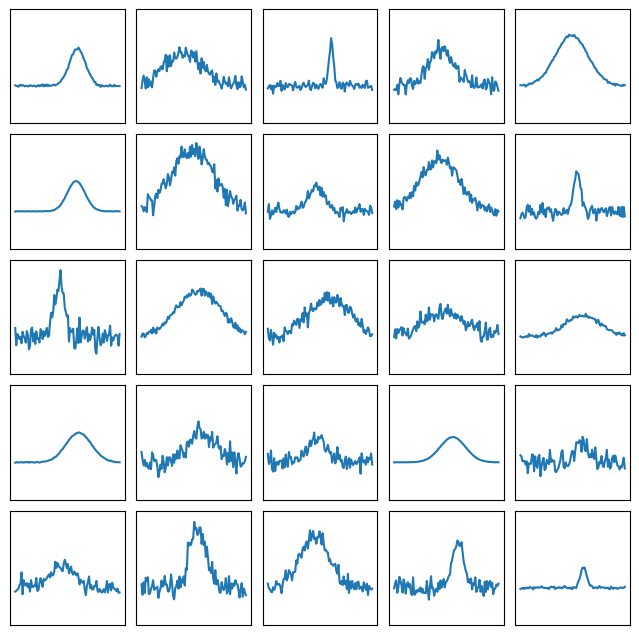

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1), dpi = 100)

x = torch.linspace(-10, 10, 100)
for ax, (y, m) in zip(axes.flat, train_loader):
    ax.plot(x, y[0])
    ax.set_ylim(-0.15, 1.0)


## **Train VAE model where our prior is conditioned on a continuous vector $c$ as $p(z|c)$. Here we pass the information about shifts as our $c$ vector.**

In [ ]:
in_dim = (100,)

# Initialize VAE (we specify c_dim=1 to add extra-dimension corresponding to c-vector to the decoder)
vae1 = pv.models.iVAE(in_dim, latent_dim=2, c_dim=1, sampler_d="gaussian",
                     sigmoid_d=False, decoder_sig=0.1)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae1)

# Train for n epochs:
for e in range(500):
    trainer.step(train_loader, scale_factor=1)
    trainer.print_statistics()

Epoch: 1 Training loss: -30.8668
Epoch: 2 Training loss: -112.4893
Epoch: 3 Training loss: -115.9618
Epoch: 4 Training loss: -117.9970
Epoch: 5 Training loss: -118.8857
Epoch: 6 Training loss: -119.2091
Epoch: 7 Training loss: -119.6481
Epoch: 8 Training loss: -120.9332
Epoch: 9 Training loss: -122.0004
Epoch: 10 Training loss: -122.6164
Epoch: 11 Training loss: -123.2358
Epoch: 12 Training loss: -123.5650
Epoch: 13 Training loss: -123.7323
Epoch: 14 Training loss: -123.3523
Epoch: 15 Training loss: -124.0394
Epoch: 16 Training loss: -124.1249
Epoch: 17 Training loss: -124.1627
Epoch: 18 Training loss: -124.4632
Epoch: 19 Training loss: -124.4692
Epoch: 20 Training loss: -124.1278
Epoch: 21 Training loss: -124.4802
Epoch: 22 Training loss: -124.4435
Epoch: 23 Training loss: -124.5161
Epoch: 24 Training loss: -124.5953
Epoch: 25 Training loss: -124.6450
Epoch: 26 Training loss: -124.5512
Epoch: 27 Training loss: -124.7079
Epoch: 28 Training loss: -124.7829
Epoch: 29 Training loss: -124.

Encode the training data into the latent space:

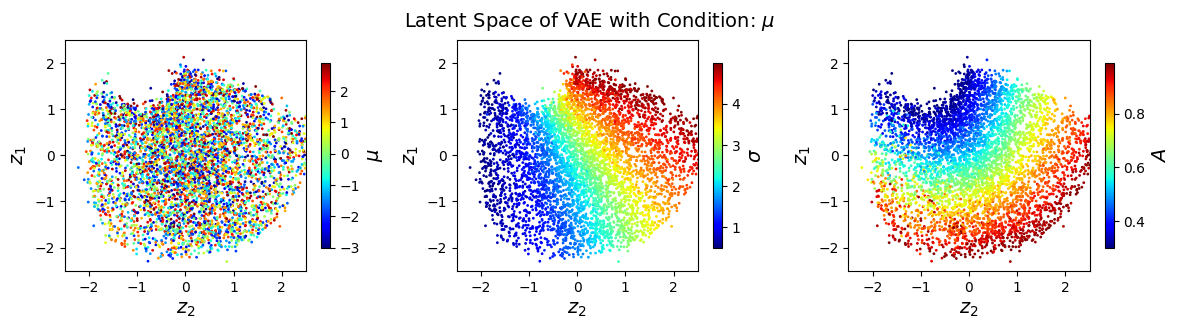

In [ ]:
z_mean, z_sd = vae1.encode(train_data)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 3))
fig.suptitle("Latent Space of VAE with Condition: $\mu$", fontsize = 14)
fig.subplots_adjust(wspace = 0.3)

im1 = ax1.scatter(z_mean[:, -1], z_mean[:, -2], s=1, c=mu_real, cmap = 'jet')
ax1.set_xlabel("$z_2$", fontsize=14)
ax1.set_ylabel("$z_1$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("$\mu$", fontsize=14)
ax1.set_xlim(-2.5, 2.5)
ax1.set_ylim(-2.5, 2.5)

im2 = ax2.scatter(z_mean[:, -1], z_mean[:, -2], s=1, c=sig_real, cmap = 'jet')
ax2.set_xlabel("$z_2$", fontsize=14)
ax2.set_ylabel("$z_1$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("$\sigma$", fontsize=14)
ax2.set_xlim(-2.5, 2.5)
ax2.set_ylim(-2.5, 2.5);

im3 = ax3.scatter(z_mean[:, -1], z_mean[:, -2], s=1, c=a_real, cmap = 'jet')
ax3.set_xlabel("$z_2$", fontsize=14)
ax3.set_ylabel("$z_1$", fontsize=14)
cbar3 = fig.colorbar(im3, ax=ax3, shrink=.8)
cbar3.set_label("$A$", fontsize=14)
ax3.set_xlim(-2.5, 2.5)
ax3.set_ylim(-2.5, 2.5);

Plot latent variables vs. ground truth

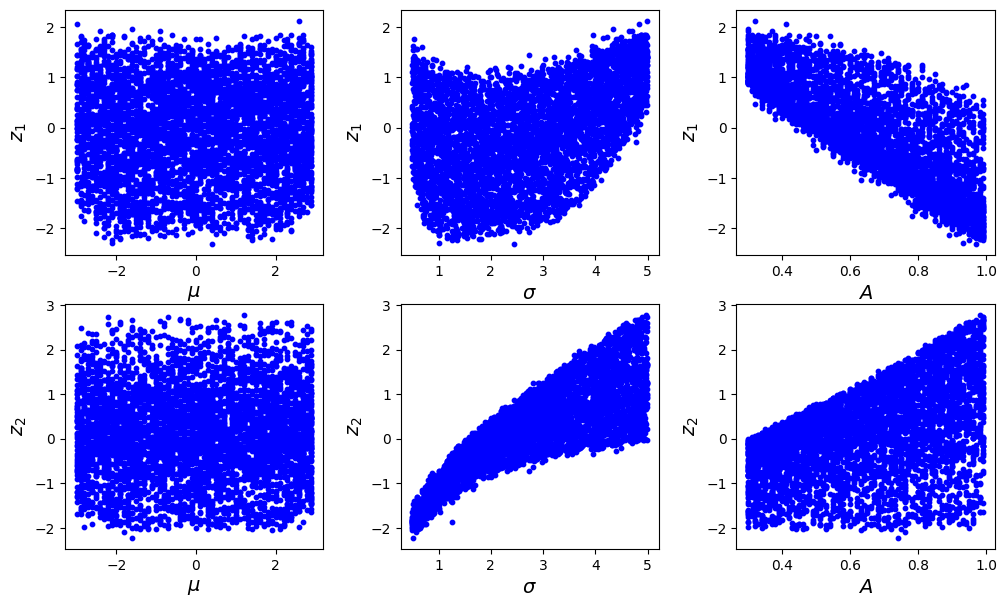

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(12, 7))
fig.subplots_adjust(wspace = 0.3)

ax[0, 0].scatter(mu_real, z_mean[:, -2], s= 10, c = "b")
ax[0, 0].set_xlabel("$\mu$", fontsize=14)
ax[0, 0].set_ylabel("$z_1$", fontsize=14)
ax[1, 0].scatter(mu_real, z_mean[:, -1], s= 10,c = "b")
ax[1, 0].set_xlabel("$\mu$", fontsize=14)
ax[1, 0].set_ylabel("$z_2$", fontsize=14)

ax[0, 1].scatter(sig_real, z_mean[:, -2], s= 10,c = "b")
ax[0, 1].set_xlabel("$\sigma$", fontsize=14)
ax[0, 1].set_ylabel("$z_1$", fontsize=14)
ax[1, 1].scatter(sig_real, z_mean[:, -1], s= 10,c = "b")
ax[1, 1].set_xlabel("$\sigma$", fontsize=14)
ax[1, 1].set_ylabel("$z_2$", fontsize=14);

ax[0, 2].scatter(a_real, z_mean[:, -2], s= 10,c = "b")
ax[0, 2].set_xlabel("$A$", fontsize=14)
ax[0, 2].set_ylabel("$z_1$", fontsize=14)
ax[1, 2].scatter(a_real, z_mean[:, -1], s= 10, c = "b")
ax[1, 2].set_xlabel("$A$", fontsize=14)
ax[1, 2].set_ylabel("$z_2$", fontsize=14);

## Our data had three factors of variation, peak position, peak width, and peak intensity. By conditioning the model on the "known" property (shift) it was able to clearly identify the unknown ones (width and intensity). Notice that [without the conditioning](https://colab.research.google.com/github/ziatdinovmax/pyroVED/blob/master/examples/shiftVAE.ipynb?authuser=1#scrollTo=B_jDOtumPm4C&line=8&uniqifier=1), the two factors of variation wouldn't be completely disentangled.

Plot the learned latent manifolds conditioned on the shift:

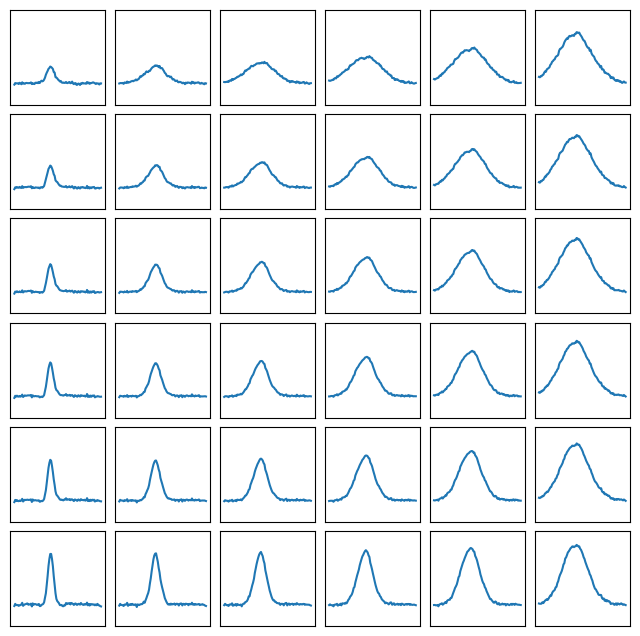

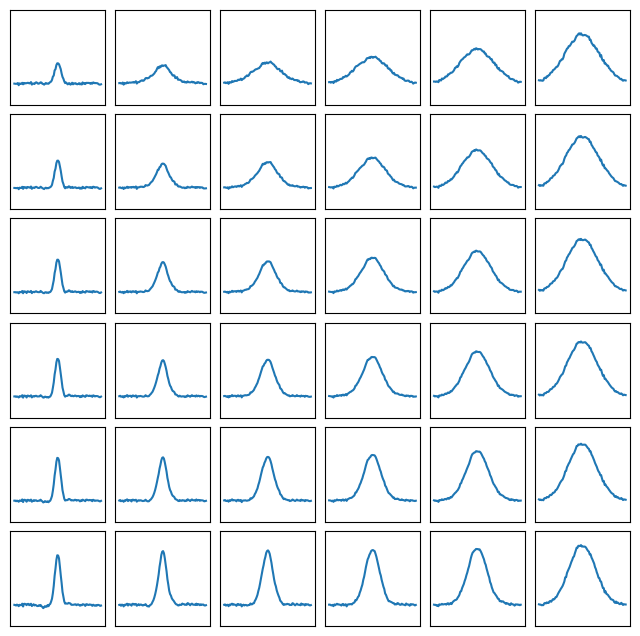

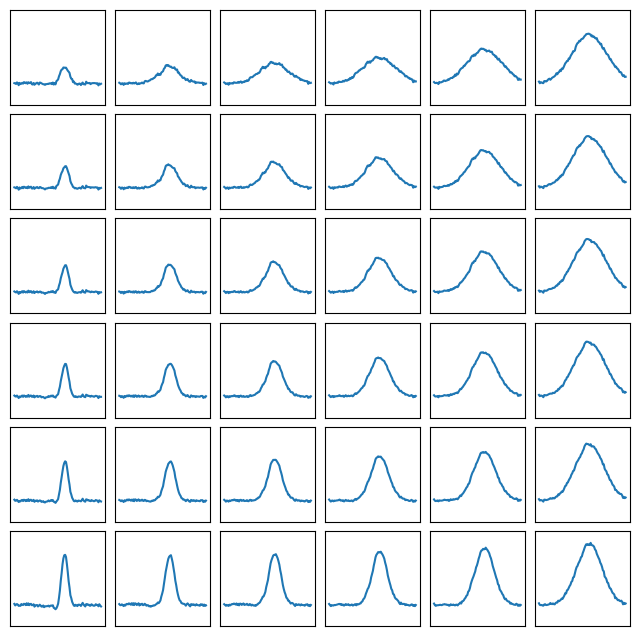

In [ ]:
y_all = [-2, 0, 2]
for y in y_all:
    y = torch.tensor(y).unsqueeze(0)
    vae1.manifold2d(6, y, ylim = [0,1])

## Now let's condition on a 2-dimensional vector containing information on the peak shifts and widths.

In [ ]:
# Initialize train loader
# train_loader = pv.utils.init_dataloader(
#     train_data.unsqueeze(1), torch.cat([mu_real, sig_real], -1), batch_size=64)

train_loader = pv.utils.init_dataloader(
    train_data, torch.cat([mu_real, sig_real], -1), batch_size=64)

In [ ]:
in_dim = (100,)

# Initialize VAE (we specify c_dim=2 to add extra dimensions corresponding to c-vector to the decoder)
vae2 = pv.models.iVAE(in_dim, latent_dim=2, c_dim=2, sampler_d="gaussian",
                     sigmoid_d=False, decoder_sig=0.1)
# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae2)

# Train for n epochs:
for e in range(500):
    trainer.step(train_loader, scale_factor=1)
    trainer.print_statistics()


Epoch: 1 Training loss: -55.0943
Epoch: 2 Training loss: -108.6539
Epoch: 3 Training loss: -119.6418
Epoch: 4 Training loss: -122.9197
Epoch: 5 Training loss: -123.9788
Epoch: 6 Training loss: -124.5777
Epoch: 7 Training loss: -124.9748
Epoch: 8 Training loss: -125.1409
Epoch: 9 Training loss: -125.5667
Epoch: 10 Training loss: -125.7730
Epoch: 11 Training loss: -125.9975
Epoch: 12 Training loss: -126.1857
Epoch: 13 Training loss: -126.3882
Epoch: 14 Training loss: -126.4010
Epoch: 15 Training loss: -126.3941
Epoch: 16 Training loss: -126.6593
Epoch: 17 Training loss: -126.7134
Epoch: 18 Training loss: -126.8700
Epoch: 19 Training loss: -126.9645
Epoch: 20 Training loss: -126.7862
Epoch: 21 Training loss: -127.0353
Epoch: 22 Training loss: -126.9771
Epoch: 23 Training loss: -127.0729
Epoch: 24 Training loss: -127.2255
Epoch: 25 Training loss: -127.1878
Epoch: 26 Training loss: -127.1613
Epoch: 27 Training loss: -127.1119
Epoch: 28 Training loss: -127.4548
Epoch: 29 Training loss: -127.

Encode the training data into the latent space:

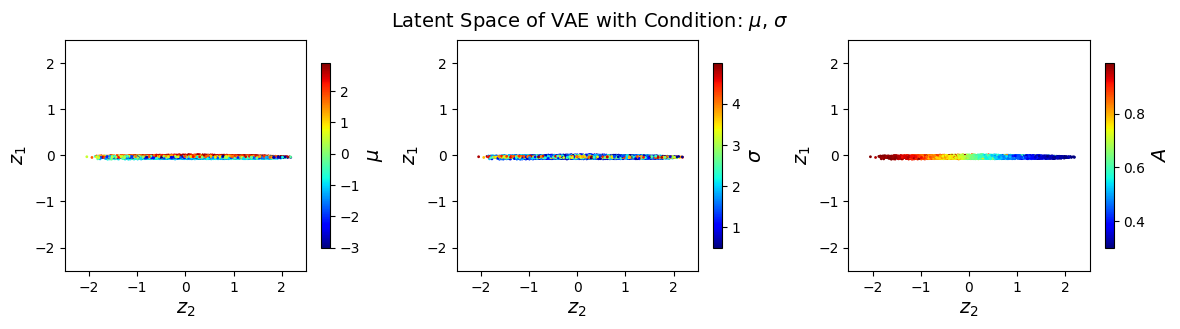

In [ ]:
z_mean, z_sd = vae2.encode(train_data)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 3))
fig.suptitle("Latent Space of VAE with Condition: $\mu$, $\sigma$", fontsize = 14)
fig.subplots_adjust(wspace = 0.3)

im1 = ax1.scatter(z_mean[:, -1], z_mean[:, -2], s=1, c=mu_real, cmap = 'jet')
ax1.set_xlabel("$z_2$", fontsize=14)
ax1.set_ylabel("$z_1$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("$\mu$", fontsize=14)
ax1.set_xlim(-2.5, 2.5)
ax1.set_ylim(-2.5, 2.5)

im2 = ax2.scatter(z_mean[:, -1], z_mean[:, -2], s=1, c=sig_real, cmap = 'jet')
ax2.set_xlabel("$z_2$", fontsize=14)
ax2.set_ylabel("$z_1$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("$\sigma$", fontsize=14)
ax2.set_xlim(-2.5, 2.5)
ax2.set_ylim(-2.5, 2.5);

im3 = ax3.scatter(z_mean[:, -1], z_mean[:, -2], s=1, c=a_real, cmap = 'jet')
ax3.set_xlabel("$z_2$", fontsize=14)
ax3.set_ylabel("$z_1$", fontsize=14)
cbar3 = fig.colorbar(im3, ax=ax3, shrink=.8)
cbar3.set_label("$A$", fontsize=14)
ax3.set_xlim(-2.5, 2.5)
ax3.set_ylim(-2.5, 2.5);

Plot latent variables vs. ground truth

Text(0, 0.5, '$z_2$')

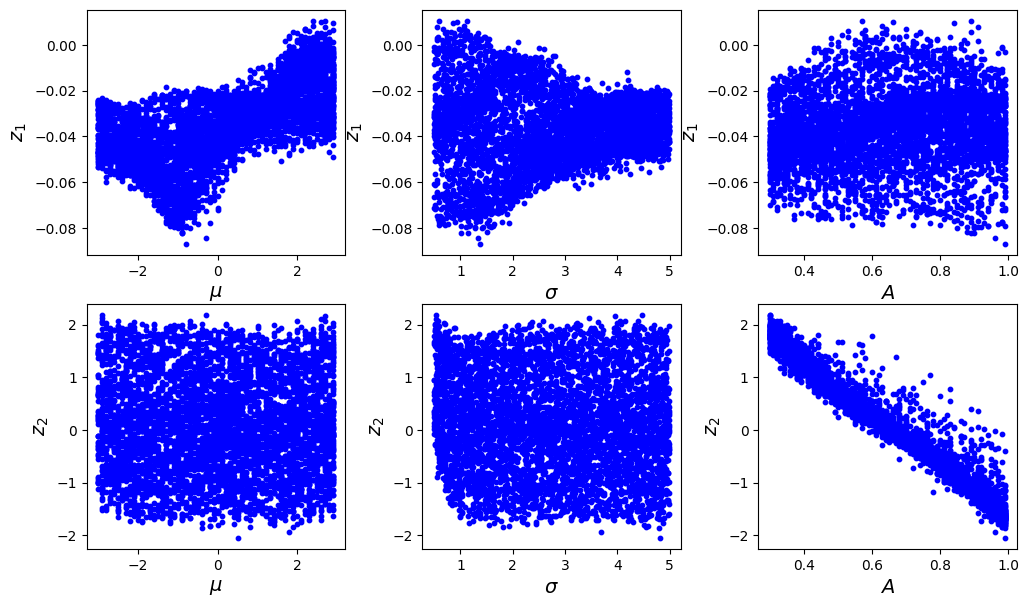

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(12, 7))
fig.subplots_adjust(wspace = 0.3)

ax[0, 0].scatter(mu_real, z_mean[:, -2], s= 10, c = "b")
ax[0, 0].set_xlabel("$\mu$", fontsize=14)
ax[0, 0].set_ylabel("$z_1$", fontsize=14)
ax[1, 0].scatter(mu_real, z_mean[:, -1], s= 10,c = "b")
ax[1, 0].set_xlabel("$\mu$", fontsize=14)
ax[1, 0].set_ylabel("$z_2$", fontsize=14)

ax[0, 1].scatter(sig_real, z_mean[:, -2], s= 10, c = "b")
ax[0, 1].set_xlabel("$\sigma$", fontsize=14)
ax[0, 1].set_ylabel("$z_1$", fontsize=14)
ax[1, 1].scatter(sig_real, z_mean[:, -1], s= 10, c = "b")
ax[1, 1].set_xlabel("$\sigma$", fontsize=14)
ax[1, 1].set_ylabel("$z_2$", fontsize=14);

ax[0, 2].scatter(a_real, z_mean[:, -2], s= 10, c = "b", label = "$z_1$")
ax[0, 2].set_xlabel("$A$", fontsize=14)
ax[0, 2].set_ylabel("$z_1$", fontsize=14)
ax[1, 2].scatter(a_real, z_mean[:, -1], s= 10, c = "b", label = "$z_2$")
ax[1, 2].set_xlabel("$A$", fontsize=14)
ax[1, 2].set_ylabel("$z_2$", fontsize=14)

## Now let's condition on a 3-dimensional vector containing information on the peak shifts, widths, and intensity.

In [ ]:
# Initialize train loader
# train_loader = pv.utils.init_dataloader(
#     train_data.unsqueeze(1), torch.cat([mu_real, sig_real, a_real], -1), batch_size=64)

train_loader = pv.utils.init_dataloader(
    train_data, torch.cat([mu_real, sig_real, a_real], -1), batch_size=64)

In [ ]:
in_dim = (100,)

# Initialize VAE (we specify c_dim=1 to add extra-dimension corresponding to c-vector to the decoder)
vae3 = pv.models.iVAE(in_dim, latent_dim=2, c_dim=3, sampler_d="gaussian",
                     sigmoid_d=False, decoder_sig=0.1)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae3)

# Train for n epochs:
for e in range(500):
    trainer.step(train_loader, scale_factor=1)
    trainer.print_statistics()

Epoch: 1 Training loss: -60.9041
Epoch: 2 Training loss: -114.3265
Epoch: 3 Training loss: -119.6382
Epoch: 4 Training loss: -122.2288
Epoch: 5 Training loss: -123.9651
Epoch: 6 Training loss: -125.2977
Epoch: 7 Training loss: -126.1058
Epoch: 8 Training loss: -126.7703
Epoch: 9 Training loss: -127.1910
Epoch: 10 Training loss: -127.5593
Epoch: 11 Training loss: -127.9081
Epoch: 12 Training loss: -128.2094
Epoch: 13 Training loss: -128.3536
Epoch: 14 Training loss: -128.5660
Epoch: 15 Training loss: -128.5730
Epoch: 16 Training loss: -128.8213
Epoch: 17 Training loss: -128.9205
Epoch: 18 Training loss: -129.0303
Epoch: 19 Training loss: -129.1761
Epoch: 20 Training loss: -129.1431
Epoch: 21 Training loss: -129.3175
Epoch: 22 Training loss: -129.4116
Epoch: 23 Training loss: -129.4556
Epoch: 24 Training loss: -129.4562
Epoch: 25 Training loss: -129.5566
Epoch: 26 Training loss: -129.5215
Epoch: 27 Training loss: -129.6306
Epoch: 28 Training loss: -129.6867
Epoch: 29 Training loss: -129.

Encode the training data into the latent space:

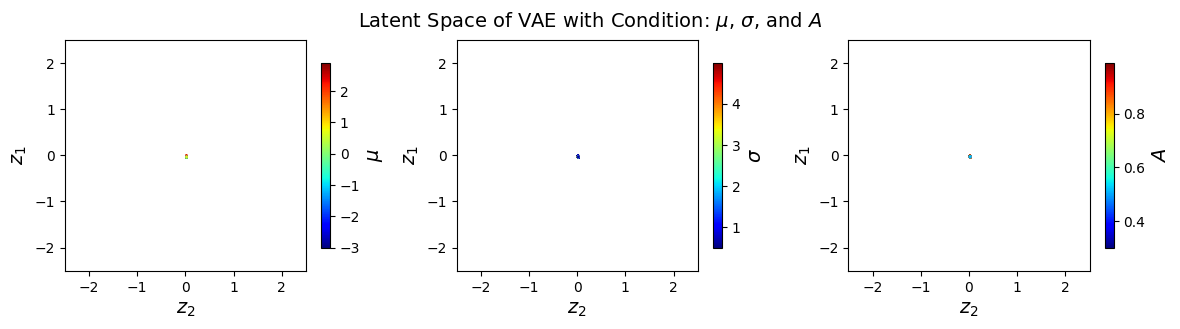

In [ ]:
z_mean, z_sd = vae3.encode(train_data)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 3))
fig.suptitle("Latent Space of VAE with Condition: $\mu$, $\sigma$, and $A$", fontsize = 14)
fig.subplots_adjust(wspace = 0.3)

im1 = ax1.scatter(z_mean[:, -1], z_mean[:, -2], s=1, c=mu_real, cmap = 'jet')
ax1.set_xlabel("$z_2$", fontsize=14)
ax1.set_ylabel("$z_1$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("$\mu$", fontsize=14)
ax1.set_xlim(-2.5, 2.5)
ax1.set_ylim(-2.5, 2.5)

im2 = ax2.scatter(z_mean[:, -1], z_mean[:, -2], s=1, c=sig_real, cmap = 'jet')
ax2.set_xlabel("$z_2$", fontsize=14)
ax2.set_ylabel("$z_1$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("$\sigma$", fontsize=14)
ax2.set_xlim(-2.5, 2.5)
ax2.set_ylim(-2.5, 2.5);

im3 = ax3.scatter(z_mean[:, -1], z_mean[:, -2], s=1, c=a_real, cmap = 'jet')
ax3.set_xlabel("$z_2$", fontsize=14)
ax3.set_ylabel("$z_1$", fontsize=14)
cbar3 = fig.colorbar(im3, ax=ax3, shrink=.8)
cbar3.set_label("$A$", fontsize=14)
ax3.set_xlim(-2.5, 2.5)
ax3.set_ylim(-2.5, 2.5);

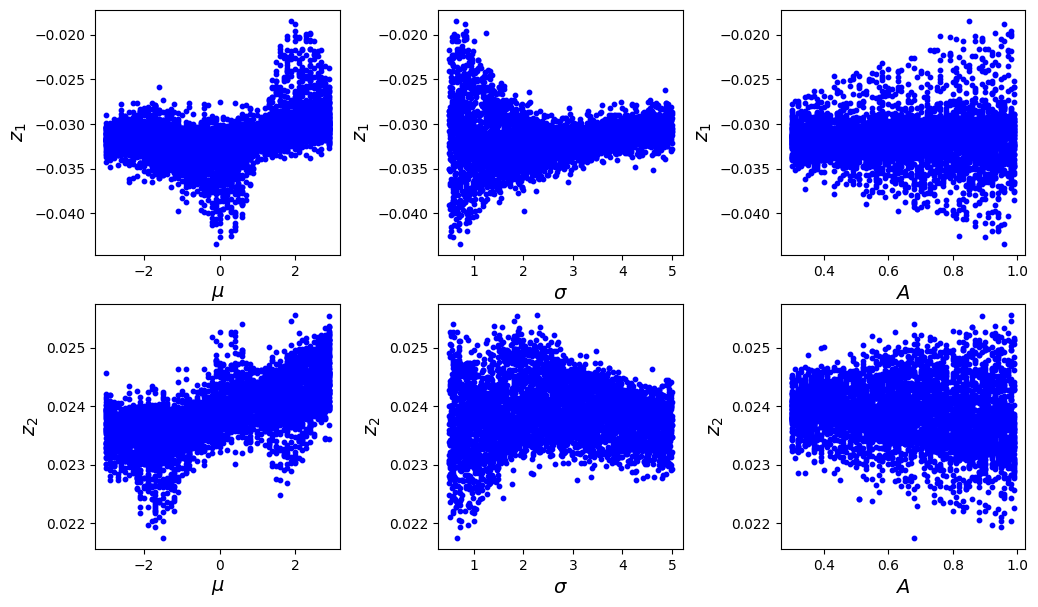

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(12, 7))
fig.subplots_adjust(wspace = 0.4)

ax[0, 0].scatter(mu_real, z_mean[:, -2], s= 10, c = "b")
ax[0, 0].set_xlabel("$\mu$", fontsize=14)
ax[0, 0].set_ylabel("$z_1$", fontsize=14)
ax[1, 0].scatter(mu_real, z_mean[:, -1], s= 10, c = "b")
ax[1, 0].set_xlabel("$\mu$", fontsize=14)
ax[1, 0].set_ylabel("$z_2$", fontsize=14)

ax[0, 1].scatter(sig_real, z_mean[:, -2], s= 10, c = "b")
ax[0, 1].set_xlabel("$\sigma$", fontsize=14)
ax[0, 1].set_ylabel("$z_1$", fontsize=14)
ax[1, 1].scatter(sig_real, z_mean[:, -1], s= 10, c = "b")
ax[1, 1].set_xlabel("$\sigma$", fontsize=14)
ax[1, 1].set_ylabel("$z_2$", fontsize=14);

ax[0, 2].scatter(a_real, z_mean[:, -2], s= 10, c = "b")
ax[0, 2].set_xlabel("$A$", fontsize=14)
ax[0, 2].set_ylabel("$z_1$", fontsize=14)
ax[1, 2].scatter(a_real, z_mean[:, -1], s= 10, c = "b")
ax[1, 2].set_xlabel("$A$", fontsize=14)
ax[1, 2].set_ylabel("$z_2$", fontsize=14);

## Now let us do VAE and shift-VAE analyses as comparason 

In [ ]:
# Initialize train loader
# train_loader = pv.utils.init_dataloader(train_data.unsqueeze(1), batch_size=64)
train_loader = pv.utils.init_dataloader(train_data, batch_size=64)

Train VAE model 

In [ ]:
in_dim = (100,)

# Initialize VAE (we specify c_dim=1 to add extra-dimension corresponding to c-vector to the decoder)
vae = pv.models.iVAE(in_dim, latent_dim=2, sampler_d="gaussian",
                     sigmoid_d=False, decoder_sig=0.1)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae)

# Train for n epochs:
for e in range(500):
    trainer.step(train_loader, scale_factor=1)
    trainer.print_statistics()

Epoch: 1 Training loss: -38.3240
Epoch: 2 Training loss: -111.6297
Epoch: 3 Training loss: -113.5957
Epoch: 4 Training loss: -114.4104
Epoch: 5 Training loss: -115.4191
Epoch: 6 Training loss: -116.0425
Epoch: 7 Training loss: -116.5834
Epoch: 8 Training loss: -117.0417
Epoch: 9 Training loss: -117.2991
Epoch: 10 Training loss: -117.3740
Epoch: 11 Training loss: -117.8260
Epoch: 12 Training loss: -117.9584
Epoch: 13 Training loss: -117.9789
Epoch: 14 Training loss: -117.9577
Epoch: 15 Training loss: -118.0834
Epoch: 16 Training loss: -118.4380
Epoch: 17 Training loss: -118.3563
Epoch: 18 Training loss: -118.5611
Epoch: 19 Training loss: -118.5739
Epoch: 20 Training loss: -118.4249
Epoch: 21 Training loss: -118.7699
Epoch: 22 Training loss: -118.6921
Epoch: 23 Training loss: -118.9066
Epoch: 24 Training loss: -118.8354
Epoch: 25 Training loss: -118.6899
Epoch: 26 Training loss: -118.8551
Epoch: 27 Training loss: -118.7340
Epoch: 28 Training loss: -118.9592
Epoch: 29 Training loss: -118.

Encode the training data into the latent space:

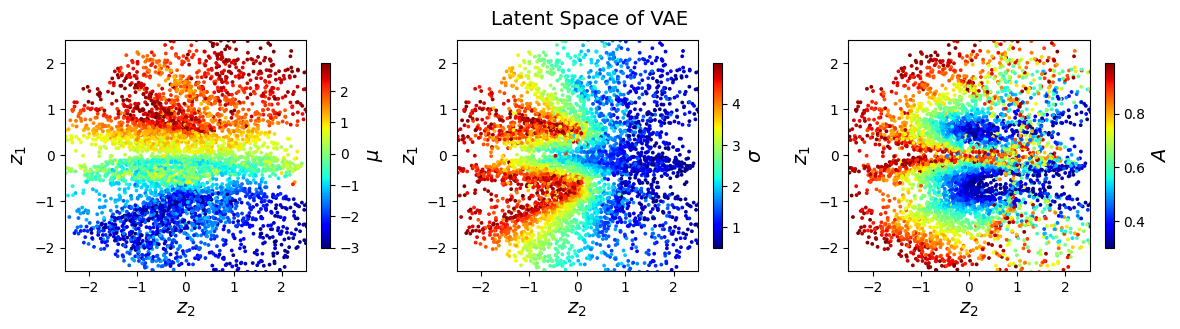

In [ ]:
z_mean, z_sd = vae.encode(train_data)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 3))
fig.suptitle("Latent Space of VAE", fontsize = 14)
fig.subplots_adjust(wspace = 0.3)

im1 = ax1.scatter(z_mean[:, -1], z_mean[:, -2], s=3, c=mu_real, cmap = 'jet')
ax1.set_xlabel("$z_2$", fontsize=14)
ax1.set_ylabel("$z_1$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("$\mu$", fontsize=14)
ax1.set_xlim(-2.5, 2.5)
ax1.set_ylim(-2.5, 2.5)

im2 = ax2.scatter(z_mean[:, -1], z_mean[:, -2], s=3, c=sig_real, cmap = 'jet')
ax2.set_xlabel("$z_2$", fontsize=14)
ax2.set_ylabel("$z_1$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("$\sigma$", fontsize=14)
ax2.set_xlim(-2.5, 2.5)
ax2.set_ylim(-2.5, 2.5);

im3 = ax3.scatter(z_mean[:, -1], z_mean[:, -2], s=3, c=a_real, cmap = 'jet')
ax3.set_xlabel("$z_2$", fontsize=14)
ax3.set_ylabel("$z_1$", fontsize=14)
cbar3 = fig.colorbar(im3, ax=ax3, shrink=.8)
cbar3.set_label("$A$", fontsize=14)
ax3.set_xlim(-2.5, 2.5)
ax3.set_ylim(-2.5, 2.5);

Plot latent variables vs. ground truth

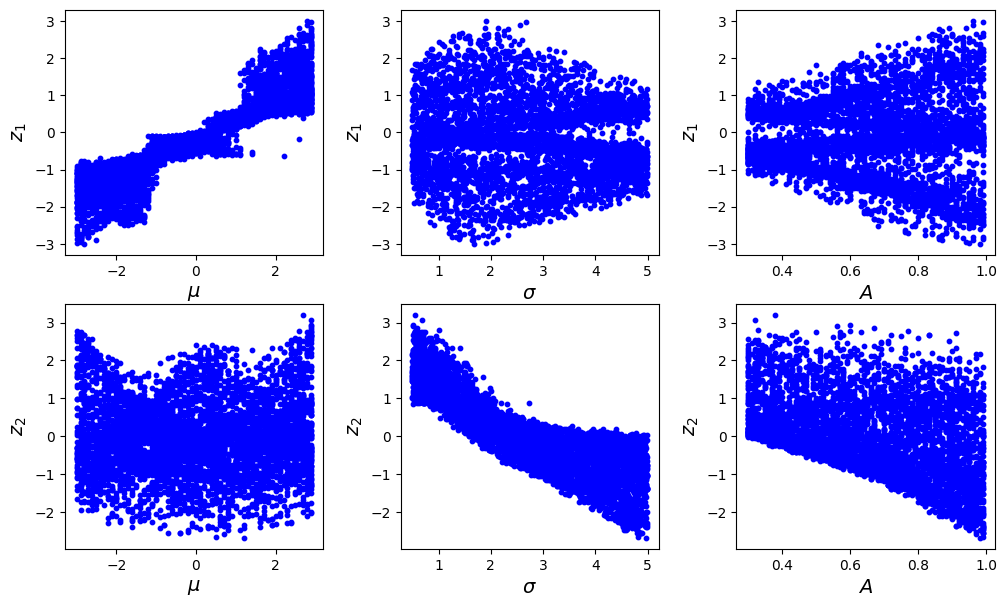

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(12, 7))
fig.subplots_adjust(wspace = 0.3)

ax[0, 0].scatter(mu_real, z_mean[:, -2], s= 10, c = "b")
ax[0, 0].set_xlabel("$\mu$", fontsize=14)
ax[0, 0].set_ylabel("$z_1$", fontsize=14)
ax[1, 0].scatter(mu_real, z_mean[:, -1], s= 10, c = "b")
ax[1, 0].set_xlabel("$\mu$", fontsize=14)
ax[1, 0].set_ylabel("$z_2$", fontsize=14)

ax[0, 1].scatter(sig_real, z_mean[:, -2], s= 10, c = "b")
ax[0, 1].set_xlabel("$\sigma$", fontsize=14)
ax[0, 1].set_ylabel("$z_1$", fontsize=14)
ax[1, 1].scatter(sig_real, z_mean[:, -1], s= 10, c = "b")
ax[1, 1].set_xlabel("$\sigma$", fontsize=14)
ax[1, 1].set_ylabel("$z_2$", fontsize=14);

ax[0, 2].scatter(a_real, z_mean[:, -2], s= 10, c = "b")
ax[0, 2].set_xlabel("$A$", fontsize=14)
ax[0, 2].set_ylabel("$z_1$", fontsize=14)
ax[1, 2].scatter(a_real, z_mean[:, -1], s= 10, c = "b")
ax[1, 2].set_xlabel("$A$", fontsize=14)
ax[1, 2].set_ylabel("$z_2$", fontsize=14);

## Train shift-VAE model 

In [ ]:
in_dim = (100,)

# Initialize VAE (we specify c_dim=1 to add extra-dimension corresponding to c-vector to the decoder)
tvae = pv.models.iVAE(in_dim, latent_dim=2, invariances='t', sampler_d="gaussian",
                     sigmoid_d=False, decoder_sig=0.1)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(tvae)

# Train for n epochs:
for e in range(500):
    trainer.step(train_loader, scale_factor=1)
    trainer.print_statistics()

Epoch: 1 Training loss: -37.4540
Epoch: 2 Training loss: -97.9358
Epoch: 3 Training loss: -111.3517
Epoch: 4 Training loss: -113.6174
Epoch: 5 Training loss: -114.5811
Epoch: 6 Training loss: -115.0429
Epoch: 7 Training loss: -115.6335
Epoch: 8 Training loss: -115.9968
Epoch: 9 Training loss: -116.4483
Epoch: 10 Training loss: -116.6982
Epoch: 11 Training loss: -117.1824
Epoch: 12 Training loss: -117.3878
Epoch: 13 Training loss: -117.5998
Epoch: 14 Training loss: -117.7678
Epoch: 15 Training loss: -117.9084
Epoch: 16 Training loss: -118.0159
Epoch: 17 Training loss: -118.3455
Epoch: 18 Training loss: -118.5159
Epoch: 19 Training loss: -118.7484
Epoch: 20 Training loss: -118.8537
Epoch: 21 Training loss: -118.9410
Epoch: 22 Training loss: -119.2601
Epoch: 23 Training loss: -120.1305
Epoch: 24 Training loss: -121.3448
Epoch: 25 Training loss: -121.7612
Epoch: 26 Training loss: -121.8873
Epoch: 27 Training loss: -122.2599
Epoch: 28 Training loss: -122.5044
Epoch: 29 Training loss: -122.6

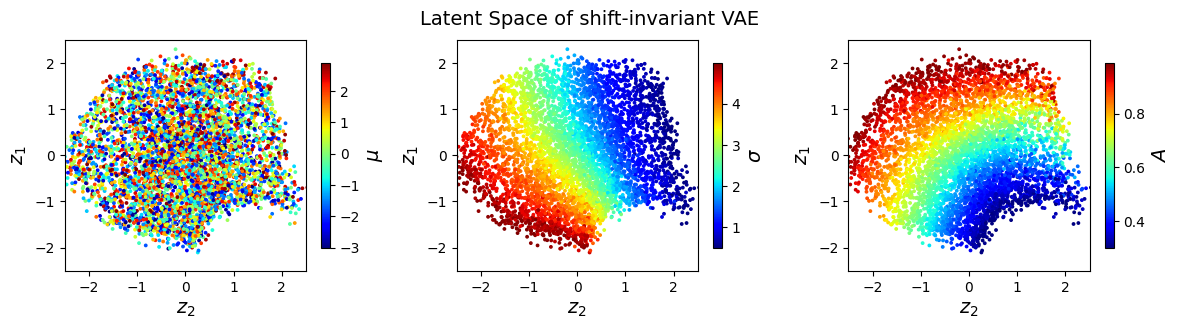

In [ ]:
z_mean, z_sd = tvae.encode(train_data)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 3))
fig.suptitle("Latent Space of shift-invariant VAE", fontsize = 14)
fig.subplots_adjust(wspace = 0.3)

im1 = ax1.scatter(z_mean[:, -1], z_mean[:, -2], s=3, c=mu_real, cmap = 'jet')
ax1.set_xlabel("$z_2$", fontsize=14)
ax1.set_ylabel("$z_1$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("$\mu$", fontsize=14)
ax1.set_xlim(-2.5, 2.5)
ax1.set_ylim(-2.5, 2.5)

im2 = ax2.scatter(z_mean[:, -1], z_mean[:, -2], s=3, c=sig_real, cmap = 'jet')
ax2.set_xlabel("$z_2$", fontsize=14)
ax2.set_ylabel("$z_1$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("$\sigma$", fontsize=14)
ax2.set_xlim(-2.5, 2.5)
ax2.set_ylim(-2.5, 2.5);

im3 = ax3.scatter(z_mean[:, -1], z_mean[:, -2], s=3, c=a_real, cmap = 'jet')
ax3.set_xlabel("$z_2$", fontsize=14)
ax3.set_ylabel("$z_1$", fontsize=14)
cbar3 = fig.colorbar(im3, ax=ax3, shrink=.8)
cbar3.set_label("$A$", fontsize=14)
ax3.set_xlim(-2.5, 2.5)
ax3.set_ylim(-2.5, 2.5);

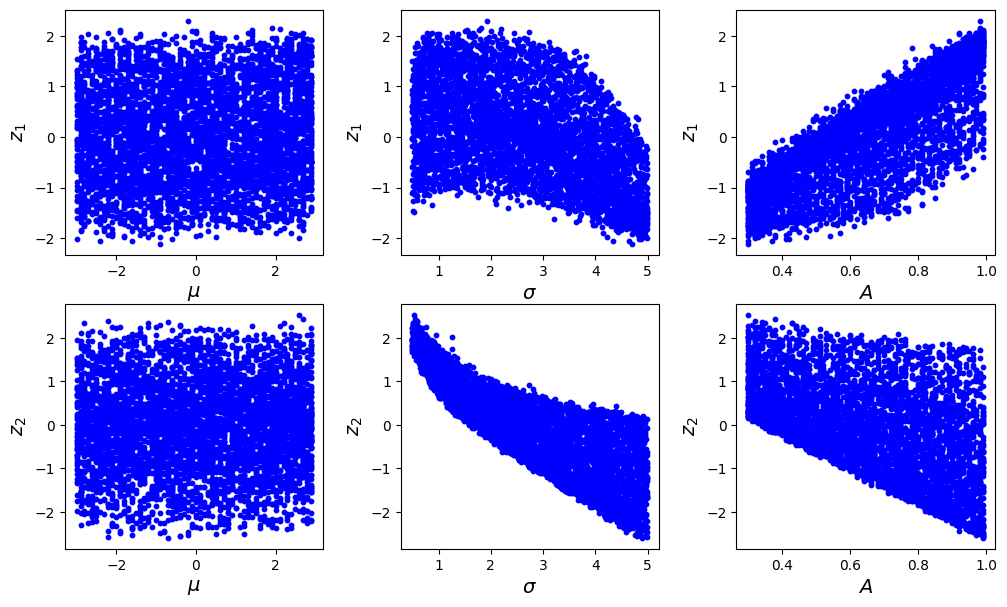

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(12, 7))
fig.subplots_adjust(wspace = 0.3)

ax[0, 0].scatter(mu_real, z_mean[:, -2], s= 10, c = "b")
ax[0, 0].set_xlabel("$\mu$", fontsize=14)
ax[0, 0].set_ylabel("$z_1$", fontsize=14)
ax[1, 0].scatter(mu_real, z_mean[:, -1], s= 10, c = "b")
ax[1, 0].set_xlabel("$\mu$", fontsize=14)
ax[1, 0].set_ylabel("$z_2$", fontsize=14)

ax[0, 1].scatter(sig_real, z_mean[:, -2], s= 10, c = "b")
ax[0, 1].set_xlabel("$\sigma$", fontsize=14)
ax[0, 1].set_ylabel("$z_1$", fontsize=14)
ax[1, 1].scatter(sig_real, z_mean[:, -1], s= 10, c = "b")
ax[1, 1].set_xlabel("$\sigma$", fontsize=14)
ax[1, 1].set_ylabel("$z_2$", fontsize=14);

ax[0, 2].scatter(a_real, z_mean[:, -2], s= 10, c = "b")
ax[0, 2].set_xlabel("$A$", fontsize=14)
ax[0, 2].set_ylabel("$z_1$", fontsize=14)
ax[1, 2].scatter(a_real, z_mean[:, -1], s= 10, c = "b")
ax[1, 2].set_xlabel("$A$", fontsize=14)
ax[1, 2].set_ylabel("$z_2$", fontsize=14);

Plot shift-variable vs. ground truth

Text(0, 0.5, 'shift variable')

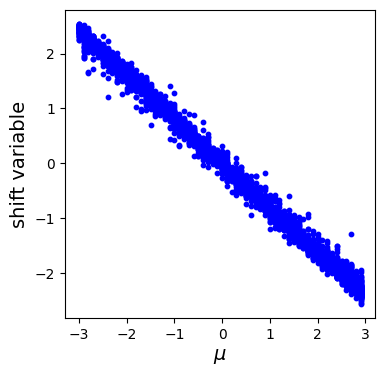

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(mu_real, z_mean[:, 0], s= 10, c = "b")
ax.set_xlabel("$\mu$", fontsize=14)
ax.set_ylabel("shift variable", fontsize=14)

In [ ]:
# Initialize train loader
# train_loader = pv.utils.init_dataloader(train_data.unsqueeze(1), batch_size=64)
train_loader = pv.utils.init_dataloader(train_data, batch_size=64)

In [ ]:
in_dim = (100,)

# Initialize VAE 
vae_l3 = pv.models.iVAE(in_dim, latent_dim=3, sampler_d="gaussian",
                     sigmoid_d=False, decoder_sig=0.1)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae_l3)

# Train for n epochs:
for e in range(500):
    trainer.step(train_loader, scale_factor=1)
    trainer.print_statistics()

Epoch: 1 Training loss: -31.5320
Epoch: 2 Training loss: -106.4456
Epoch: 3 Training loss: -112.5859
Epoch: 4 Training loss: -113.6114
Epoch: 5 Training loss: -114.4268
Epoch: 6 Training loss: -115.0409
Epoch: 7 Training loss: -115.7837
Epoch: 8 Training loss: -116.3940
Epoch: 9 Training loss: -116.6418
Epoch: 10 Training loss: -117.7460
Epoch: 11 Training loss: -120.6588
Epoch: 12 Training loss: -121.5438
Epoch: 13 Training loss: -121.7080
Epoch: 14 Training loss: -122.1019
Epoch: 15 Training loss: -122.2697
Epoch: 16 Training loss: -122.4225
Epoch: 17 Training loss: -122.3768
Epoch: 18 Training loss: -122.6241
Epoch: 19 Training loss: -122.6075
Epoch: 20 Training loss: -122.7173
Epoch: 21 Training loss: -122.7605
Epoch: 22 Training loss: -122.7505
Epoch: 23 Training loss: -122.8375
Epoch: 24 Training loss: -122.8324
Epoch: 25 Training loss: -122.7429
Epoch: 26 Training loss: -122.8869
Epoch: 27 Training loss: -122.9339
Epoch: 28 Training loss: -122.9223
Epoch: 29 Training loss: -122.

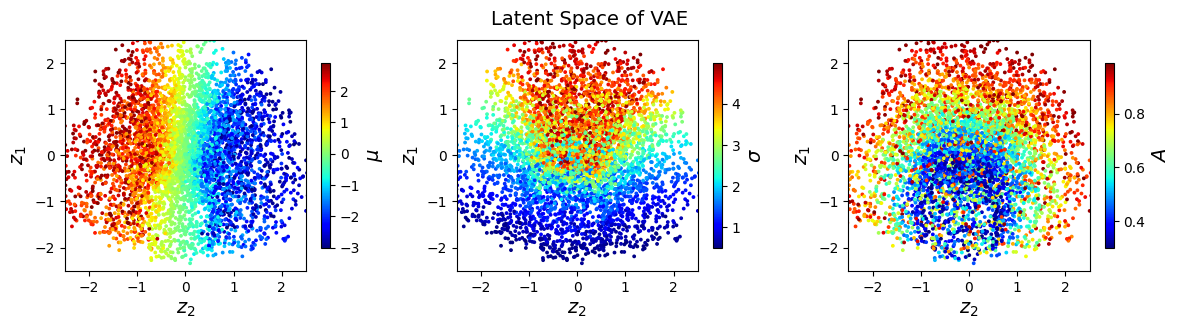

In [ ]:
z_mean, z_sd = vae_l3.encode(train_data)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 3))
fig.suptitle("Latent Space of VAE", fontsize = 14)
fig.subplots_adjust(wspace = 0.3)

im1 = ax1.scatter(z_mean[:, -1], z_mean[:, -2], s=3, c=mu_real, cmap = 'jet')
ax1.set_xlabel("$z_2$", fontsize=14)
ax1.set_ylabel("$z_1$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("$\mu$", fontsize=14)
ax1.set_xlim(-2.5, 2.5)
ax1.set_ylim(-2.5, 2.5)

im2 = ax2.scatter(z_mean[:, -1], z_mean[:, -2], s=3, c=sig_real, cmap = 'jet')
ax2.set_xlabel("$z_2$", fontsize=14)
ax2.set_ylabel("$z_1$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("$\sigma$", fontsize=14)
ax2.set_xlim(-2.5, 2.5)
ax2.set_ylim(-2.5, 2.5);

im3 = ax3.scatter(z_mean[:, -1], z_mean[:, -2], s=3, c=a_real, cmap = 'jet')
ax3.set_xlabel("$z_2$", fontsize=14)
ax3.set_ylabel("$z_1$", fontsize=14)
cbar3 = fig.colorbar(im3, ax=ax3, shrink=.8)
cbar3.set_label("$A$", fontsize=14)
ax3.set_xlim(-2.5, 2.5)
ax3.set_ylim(-2.5, 2.5);

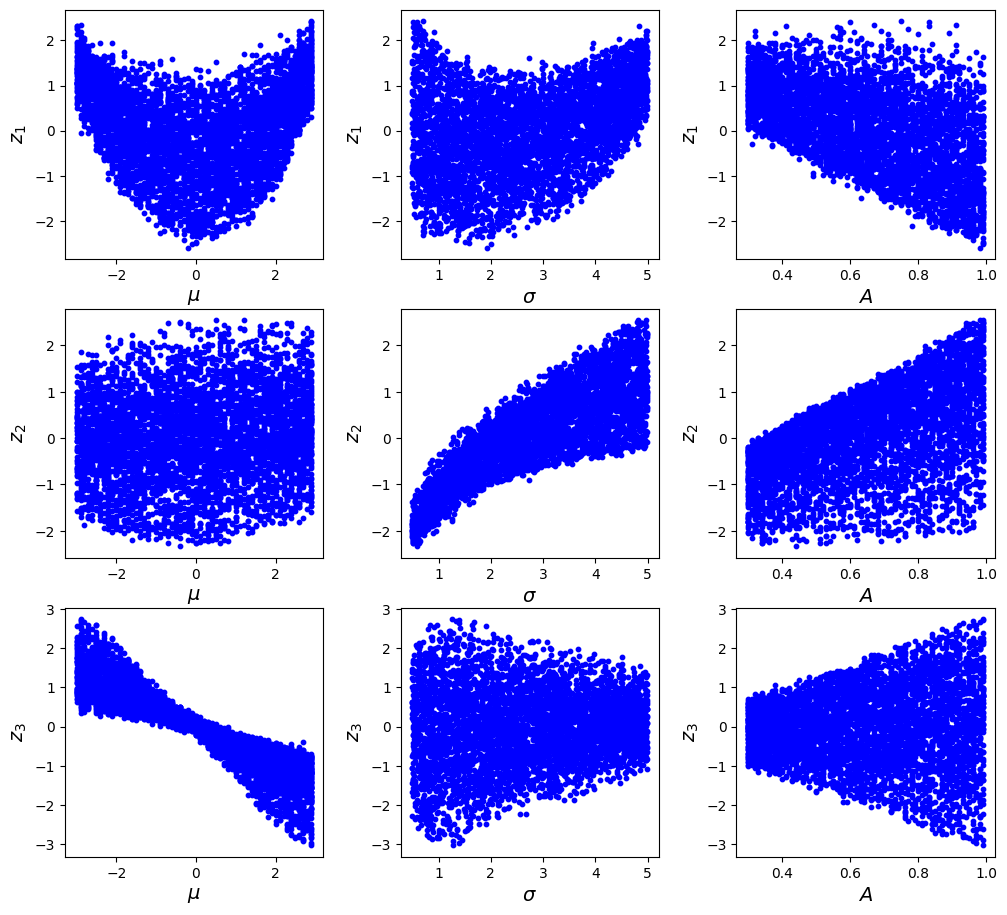

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(12, 11))
fig.subplots_adjust(wspace = 0.3)

ax[0, 0].scatter(mu_real, z_mean[:, -3], s= 10, c = "b")
ax[0, 0].set_xlabel("$\mu$", fontsize=14)
ax[0, 0].set_ylabel("$z_1$", fontsize=14)
ax[1, 0].scatter(mu_real, z_mean[:, -2], s= 10, c = "b")
ax[1, 0].set_xlabel("$\mu$", fontsize=14)
ax[1, 0].set_ylabel("$z_2$", fontsize=14)
ax[2, 0].scatter(mu_real, z_mean[:, -1], s= 10, c = "b")
ax[2, 0].set_xlabel("$\mu$", fontsize=14)
ax[2, 0].set_ylabel("$z_3$", fontsize=14)

ax[0, 1].scatter(sig_real, z_mean[:, -3], s= 10, c = "b")
ax[0, 1].set_xlabel("$\sigma$", fontsize=14)
ax[0, 1].set_ylabel("$z_1$", fontsize=14)
ax[1, 1].scatter(sig_real, z_mean[:, -2], s= 10, c = "b")
ax[1, 1].set_xlabel("$\sigma$", fontsize=14)
ax[1, 1].set_ylabel("$z_2$", fontsize=14);
ax[2, 1].scatter(sig_real, z_mean[:, -1], s= 10, c = "b")
ax[2, 1].set_xlabel("$\sigma$", fontsize=14)
ax[2, 1].set_ylabel("$z_3$", fontsize=14);

ax[0, 2].scatter(a_real, z_mean[:, -3], s= 10, c = "b")
ax[0, 2].set_xlabel("$A$", fontsize=14)
ax[0, 2].set_ylabel("$z_1$", fontsize=14)
ax[1, 2].scatter(a_real, z_mean[:, -2], s= 10, c = "b")
ax[1, 2].set_xlabel("$A$", fontsize=14)
ax[1, 2].set_ylabel("$z_2$", fontsize=14);
ax[2, 2].scatter(a_real, z_mean[:, -1], s= 10, c = "b")
ax[2, 2].set_xlabel("$A$", fontsize=14)
ax[2, 2].set_ylabel("$z_3$", fontsize=14);

In [ ]:
# Initialize train loader
# train_loader = pv.utils.init_dataloader(train_data.unsqueeze(1), batch_size=64)
train_loader = pv.utils.init_dataloader(train_data, batch_size=64)

in_dim = (100,)

# Initialize VAE 
vae_l4 = pv.models.iVAE(in_dim, latent_dim=4, sampler_d="gaussian",
                     sigmoid_d=False, decoder_sig=0.1)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae_l4)

# Train for n epochs:
for e in range(500):
    trainer.step(train_loader, scale_factor=1)

    trainer.print_statistics()

Epoch: 1 Training loss: -20.2200
Epoch: 2 Training loss: -104.2826
Epoch: 3 Training loss: -112.9129
Epoch: 4 Training loss: -115.6776
Epoch: 5 Training loss: -117.0225
Epoch: 6 Training loss: -118.1705
Epoch: 7 Training loss: -119.0476
Epoch: 8 Training loss: -119.6698
Epoch: 9 Training loss: -120.3507
Epoch: 10 Training loss: -120.6898
Epoch: 11 Training loss: -121.0830
Epoch: 12 Training loss: -121.3476
Epoch: 13 Training loss: -121.5510
Epoch: 14 Training loss: -121.5784
Epoch: 15 Training loss: -121.8950
Epoch: 16 Training loss: -121.8685
Epoch: 17 Training loss: -121.3630
Epoch: 18 Training loss: -122.0538
Epoch: 19 Training loss: -122.1793
Epoch: 20 Training loss: -122.3101
Epoch: 21 Training loss: -122.4313
Epoch: 22 Training loss: -122.4818
Epoch: 23 Training loss: -122.5177
Epoch: 24 Training loss: -122.4372
Epoch: 25 Training loss: -122.5919
Epoch: 26 Training loss: -122.5694
Epoch: 27 Training loss: -122.7060
Epoch: 28 Training loss: -122.6952
Epoch: 29 Training loss: -122.

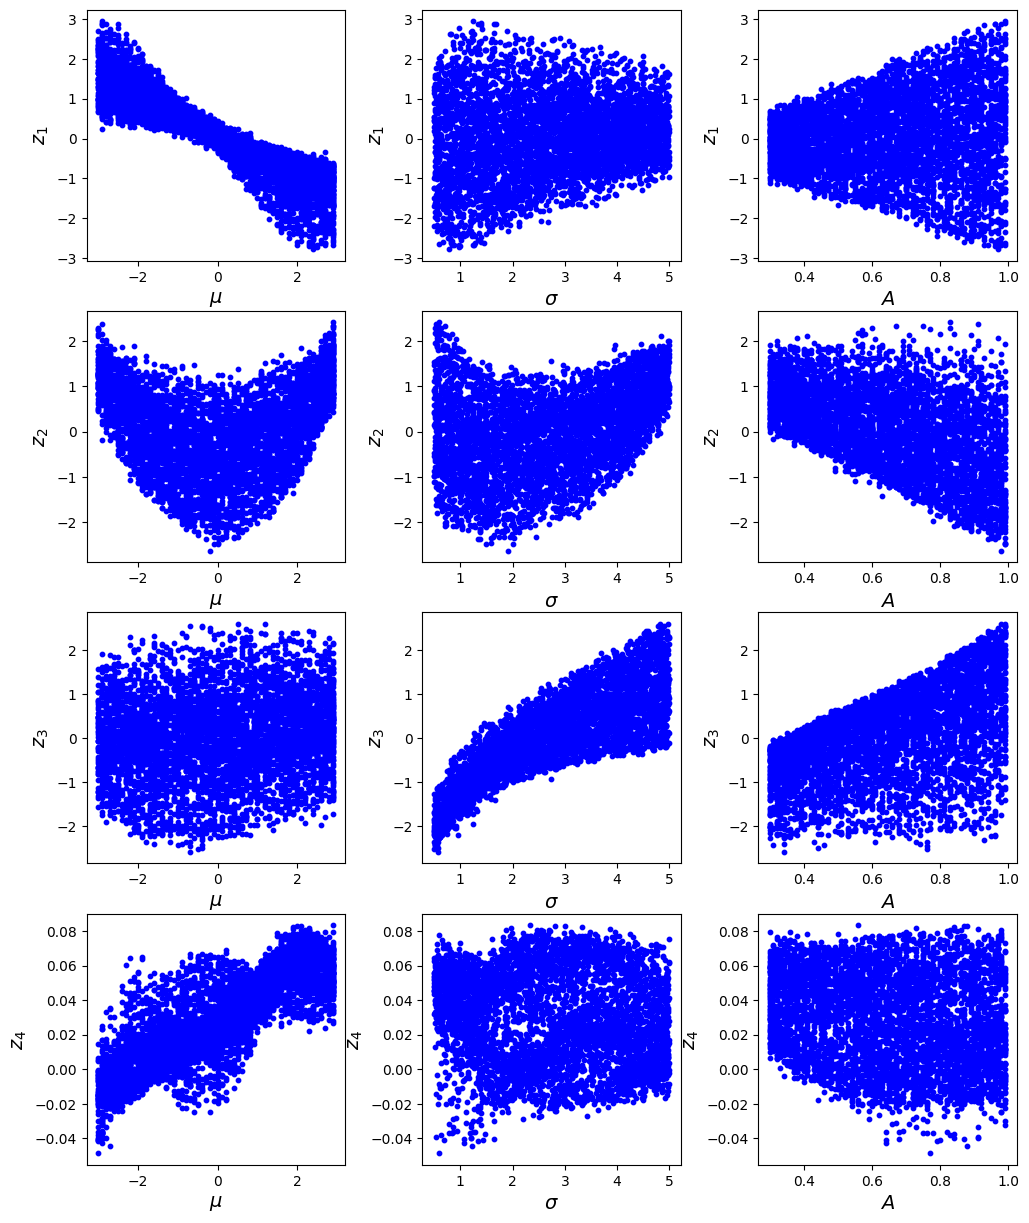

In [ ]:
z_mean, z_sd = vae_l4.encode(train_data)

fig, ax = plt.subplots(4, 3, figsize=(12, 15))
fig.subplots_adjust(wspace = 0.3)

ax[0, 0].scatter(mu_real, z_mean[:, -4], s= 10, c = "b")
ax[0, 0].set_xlabel("$\mu$", fontsize=14)
ax[0, 0].set_ylabel("$z_1$", fontsize=14)
ax[1, 0].scatter(mu_real, z_mean[:, -3], s= 10, c = "b")
ax[1, 0].set_xlabel("$\mu$", fontsize=14)
ax[1, 0].set_ylabel("$z_2$", fontsize=14)
ax[2, 0].scatter(mu_real, z_mean[:, -2], s= 10, c = "b")
ax[2, 0].set_xlabel("$\mu$", fontsize=14)
ax[2, 0].set_ylabel("$z_3$", fontsize=14)
ax[3, 0].scatter(mu_real, z_mean[:, -1], s= 10, c = "b")
ax[3, 0].set_xlabel("$\mu$", fontsize=14)
ax[3, 0].set_ylabel("$z_4$", fontsize=14)

ax[0, 1].scatter(sig_real, z_mean[:, -4], s= 10, c = "b")
ax[0, 1].set_xlabel("$\sigma$", fontsize=14)
ax[0, 1].set_ylabel("$z_1$", fontsize=14)
ax[1, 1].scatter(sig_real, z_mean[:, -3], s= 10, c = "b")
ax[1, 1].set_xlabel("$\sigma$", fontsize=14)
ax[1, 1].set_ylabel("$z_2$", fontsize=14);
ax[2, 1].scatter(sig_real, z_mean[:, -2], s= 10, c = "b")
ax[2, 1].set_xlabel("$\sigma$", fontsize=14)
ax[2, 1].set_ylabel("$z_3$", fontsize=14);
ax[3, 1].scatter(sig_real, z_mean[:, -1], s= 10, c = "b")
ax[3, 1].set_xlabel("$\sigma$", fontsize=14)
ax[3, 1].set_ylabel("$z_4$", fontsize=14);

ax[0, 2].scatter(a_real, z_mean[:, -4], s= 10, c = "b")
ax[0, 2].set_xlabel("$A$", fontsize=14)
ax[0, 2].set_ylabel("$z_1$", fontsize=14)
ax[1, 2].scatter(a_real, z_mean[:, -3], s= 10, c = "b")
ax[1, 2].set_xlabel("$A$", fontsize=14)
ax[1, 2].set_ylabel("$z_2$", fontsize=14);
ax[2, 2].scatter(a_real, z_mean[:, -2], s= 10, c = "b")
ax[2, 2].set_xlabel("$A$", fontsize=14)
ax[2, 2].set_ylabel("$z_3$", fontsize=14);
ax[3, 2].scatter(a_real, z_mean[:, -1], s= 10, c = "b")
ax[3, 2].set_xlabel("$A$", fontsize=14)
ax[3, 2].set_ylabel("$z_4$", fontsize=14);